 http://wsa.roe.ac.uk/flatFiles.html#catmags

In [1]:
import numpy as np
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
import bz2
import pdb
import warnings
import os
from astropy import wcs
plt.rcParams['text.usetex']=True
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25 
import Image,ImageOps
import urllib, cStringIO


%matplotlib inline
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec

from astropy.coordinates import SkyCoord
from photutils import CircularAperture
import astropy.units as u
from photutils import aperture_photometry
from photutils import Background2D, SigmaClip, MedianBackground

In [2]:
data = Table.read('../data/ukidss_gz2_rh_debiased.fits')

In [3]:
def tsf_params(tsf):
    r_zero=tsf[1].data.aa[0][2]
    r_kk=tsf[1].data.kk[0][2]
    r_airmass = tsf[1].data.airmass[0][2]
    
    return r_zero,r_kk,r_airmass

def counts_to_f_f0(cutout,r_zero,r_kk,r_airmass,exp_time=53.907):
    #cutout in counts
    f_f0 = (cutout/exp_time)*(10**(.4*(r_zero+r_kk*r_airmass)))
    return f_f0

def flux_to_mag(f_f0):
    b=1.2*10**(-10)
    mag = -(2.5/np.log(10))*(np.arcsinh((f_f0)/(2*b))+np.log(b))
    return mag

def subtract_sky(cutout,box_int,edge_method='crop'):
    box_size=int(cutout.shape[0]/box_int)
    bkg_estimator = MedianBackground()
    bkg = Background2D(cutout,box_size=box_size,edge_method=edge_method)
    cutout = cutout - bkg.background
    return cutout,bkg.background

def crop_ukidss_cutout(cutout,sdss_width):
    #sdss_width = sdss cutout.shape[0]
    trim_length = int((cutout.shape[0]-sdss_width)/2.)
    extents = [trim_length, trim_length+sdss_width,trim_length,trim_length+sdss_width]

    return cutout[extents[0]:extents[1], extents[2]:extents[3]]
    
def get_sb_profile(gal,frame,tsf):

    ra = gal['RA']
    dec = gal['DEC']
    rad = gal['petrorad_r']
    
    img = frame[0].data
    hdr = frame[0].header

    #get coordinates of subject
    w = wcs.WCS(hdr)
    pix = w.wcs_world2pix(ra, dec,1)
    row, col = int(pix[1]), int(pix[0])

    size = 6. #total size of cutout = 8*petro_r
    extents = [int(row-size*rad), int(row+size*rad), int(col-size*rad), int(col+size*rad)] 
    cutout = img[extents[0]:extents[1], extents[2]:extents[3]]

    #zeropoints, extinction, and airmass 
    r_zero,r_kk,r_airmass = tsf_params(tsf)
    
    center_pix = cutout.shape[0]/2+1 #center of galaxy / cutout
    positions = [(center_pix,center_pix)] #center of aperture
    radii = np.linspace(1,center_pix-1,100) #100 apertures
    
    #subtract padding from cutout
    cutout = cutout - hdr['SOFTBIAS']
    
    #subtract sky 
    cutout_minus_bkg,bkg = subtract_sky(cutout,5)
    
    surface_brightness = []
    surface_brightness_bkg = []
    for r in radii: #calculate counts for each aperture with radius r
        apertures = CircularAperture(positions,r=r)
        phot_table = aperture_photometry(cutout,apertures,method='subpixel')
        phot_table_bkg = aperture_photometry(bkg,apertures,method='subpixel')
        counts_in_aperture = phot_table['aperture_sum']
        counts_in_aperture_bkg = phot_table_bkg['aperture_sum']

        flux_in_aperture = counts_to_f_f0(counts_in_aperture,r_zero,r_kk,r_airmass) #convert counts to f/f0
        flux_in_aperture_bkg = counts_to_f_f0(counts_in_aperture_bkg,r_zero,r_kk,r_airmass) 
        
        area = np.pi*(r**2)*.396 #area in arcsec
        flux_per_area = flux_in_aperture/area #get flux per arcsec 
        flux_per_area_bkg = flux_in_aperture_bkg/area  

        
        surface_brightness.append(flux_to_mag(flux_per_area)) #convert flux/arsec to mag/arcsec, store in list
        surface_brightness_bkg.append(flux_to_mag(flux_per_area_bkg)) 

    return cutout,radii*.396,surface_brightness,surface_brightness_bkg  

def get_sb_ukidss(fits_file):
    extcorr=-1*fits_file[1].header['EXTINCT']*(((fits_file[0].header['AMSTART']+fits_file[0].header['AMEND'])/2)-1)
    texpcorr = 2.5*np.log10(fits_file[0].header['EXP_TIME'])
    magzpt = fits_file[1].header['MAGZPT']
    
    cutout=fits_file[1].data
    
    center_pix = cutout.shape[0]/2+1 #center of galaxy / cutout
    positions = [(center_pix,center_pix)] #center of aperture
    radii = np.linspace(1,center_pix-1,100) #100 apertures
    
    #subtract sky 
    cutout_minus_bkg,bkg = subtract_sky(cutout,5)
    
    surface_brightness = []
    surface_brightness_bkg = []
    for r in radii: #calculate flux for each aperture with radius r
        apertures = CircularAperture(positions,r=r)
        phot_table = aperture_photometry(cutout,apertures,method='subpixel')
        phot_table_bkg = aperture_photometry(bkg,apertures,method='subpixel')
        flux_in_aperture = phot_table['aperture_sum']
        flux_in_aperture_bkg = phot_table_bkg['aperture_sum']

        area = np.pi*(r**2)*.4 #area in arcsec
        flux_per_area = flux_in_aperture/area #get flux per arcsec 
        flux_per_area_bkg = flux_in_aperture_bkg/area #get flux per arcsec 
        
        #convert flux/arsec to mag/arcsec, store in list
        surface_brightness.append(-2.5*np.log10(flux_per_area)+ magzpt + extcorr + texpcorr) 
        surface_brightness_bkg.append(-2.5*np.log10(flux_per_area_bkg)+ magzpt + extcorr + texpcorr) 

    return cutout,radii*.4,surface_brightness,surface_brightness_bkg

In [4]:
def get_file_downloadname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'http://das.sdss.org/raw/'+'{:03d}'.format(r)+'/'+'{:1d}'.format(rr)+'/corr/'+'{:1d}'.format(c)+'/fpC-'+'{:06d}'.format(r)+'-r'+'{:1d}'.format(c)+'-'+'{:04d}'.format(f)+'.fit.gz'+'\n'
    return strname

def get_tsf_downloadname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']    
    strname = 'http://das.sdss.org/imaging/{:1d}/{:1d}/calibChunks/{:1d}/tsField-{:06d}-{:1d}-{:1d}-{:04d}.fit'.format(r,rr,c,r,c,rr,f)
    return strname

def get_filename(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'dr7_frames/fpC-'+'{:06d}'.format(r)+'-r'+'{:1d}'.format(c)+'-'+'{:04d}'.format(f)+'.fit.gz'
    return strname

def get_tsfname(gal):
    r = gal['RUN']
    c = gal['CAMCOL']
    f = gal['FIELD']
    rr = gal['RERUN']
    strname = strname = 'dr7_frames/tsField-'+'{:06d}-'.format(r)+'{:1d}'.format(c)+'-'+'{:1d}-'.format(rr)+'{:04d}'.format(f)+'.fit'
    return strname

def get_ukidss_file(gal):
    strname = 'ukidss_frames/{:1d}_J.fits'.format(gal['dr7objid'])
    return strname

#function for getting galaxy images
def optical_image(gal):
    
    pixelsize=0.396
    height=500
    width=500

    scale=2.5*gal['PETROR90_R']/pixelsize/width
    # form wurl to query SDSS web sevice to generate cutout image
    cutOutImageUrl="http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx?ra=" + str(gal['RA'])
    cutOutImageUrl += "&dec=" + str(gal['DEC']) + "&scale=""" + str(scale) + "&width=" + str(width)
    cutOutImageUrl += "&height=" + str(height)
    
    file = cStringIO.StringIO(urllib.urlopen(cutOutImageUrl).read())
    img = Image.open(file)    
    return img

def IR_image(gal):
    
    
    file = cStringIO.StringIO(urllib.urlopen(gal['UKIDSS_url']).read())
    img = Image.open(file)    
    return img.crop((75, 75, 424-75, 424-75))

In [5]:
#test 10 galaxies 
vol_lim = data[(data['REDSHIFT']<0.06) & (data['PETROMAG_MR']<-20)]
gal_list=[]
for i in range(0,10):
    gal = vol_lim[i]
    gal_list.append(vol_lim[i]['dr7objid'])
    strname = 'ukidss_frames/{}_J.fits'.format(gal['dr7objid'])
    if os.path.isfile(strname)==False:
        print gal['dr7objid'],gal['RA'],gal['DEC']



In [6]:
def calc_and_plot(gal):
    frame = fits.open(get_filename(gal))
    tsf = fits.open(get_tsfname(gal))
    cutout,radii,sb,sb_bkg = get_sb_profile(gal,frame,tsf)
    
    u_frame = fits.open(get_ukidss_file(gal))
    cutout_u,radii_u,sb_u,sb_u_bkg = get_sb_ukidss(u_frame)
    
    cutout_u = crop_ukidss_cutout(cutout_u,cutout.shape[0])
    
    xmax = radii[len(radii)-1]+1
    #plot
    f=plt.figure(figsize=(25,14))
    gs = gridspec.GridSpec(2,4,width_ratios=[1,1,.75,.75])
    gs.update(wspace=.3)
    #gri image
    ax=plt.subplot(gs[0,0])
    plt.imshow(optical_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.title('gri image',fontsize=25)

    ax=plt.subplot(gs[0,1])
    plt.imshow(cutout,norm=LogNorm())
    for r in radii/.396:
        circle=plt.Circle((cutout.shape[0]/2+1,cutout.shape[0]/2+1),r,fill=False,alpha=.3)
    #    ax.add_artist(circle)
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.title('r image',fontsize=25)
    
    #YJK image
    ax=plt.subplot(gs[1,0])
    plt.imshow(IR_image(gal))
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.title('YJK image',fontsize=25)
    
    ax=plt.subplot(gs[1,1])
    plt.imshow(cutout_u,norm=LogNorm())
    #for r in radii_u/.4:
    #    circle=plt.Circle((cutout_u.shape[0]/2+1,cutout_u.shape[0]/2+1),r,fill=False,alpha=.3)
    #    ax.add_artist(circle)
    plt.tick_params(labelbottom='off',labelleft='off')
    plt.title('J image',fontsize=25)


    ax=plt.subplot(gs[0,2:])
    plt.plot(radii,sb,label='image')
    plt.plot(radii,sb_bkg,label='background')
    plt.gca().invert_yaxis()
    plt.xlabel('$\mathrm{radius~(arcsec)}$',fontsize=25)
    plt.ylabel('$\mathrm{\mu_r~(mag/arcsec^2)}$',fontsize=25)
    plt.xlim(0,xmax)
    plt.axvline(x=gal['PETROR50_R'],ls='dashed',color='k',alpha=.5,label='R50,R90')
    plt.axvline(x=gal['PETROR90_R'],ls='dashed',color='k',alpha=.5)
    plt.legend(fontsize=20)
    
    ax=plt.subplot(gs[1,2:])
    plt.plot(radii_u,sb_u)
    plt.plot(radii_u,sb_u_bkg)
    plt.gca().invert_yaxis()
    plt.xlabel('$\mathrm{radius~(arcsec)}$',fontsize=25)
    plt.ylabel('$\mathrm{\mu_J~(mag/arcsec^2)}$',fontsize=25)
    plt.xlim(0,xmax)
    plt.axvline(x=gal['PETROR50_R'],ls='dashed',color='k',alpha=.5)
    plt.axvline(x=gal['PETROR90_R'],ls='dashed',color='k',alpha=.5,label='petrorad_r')



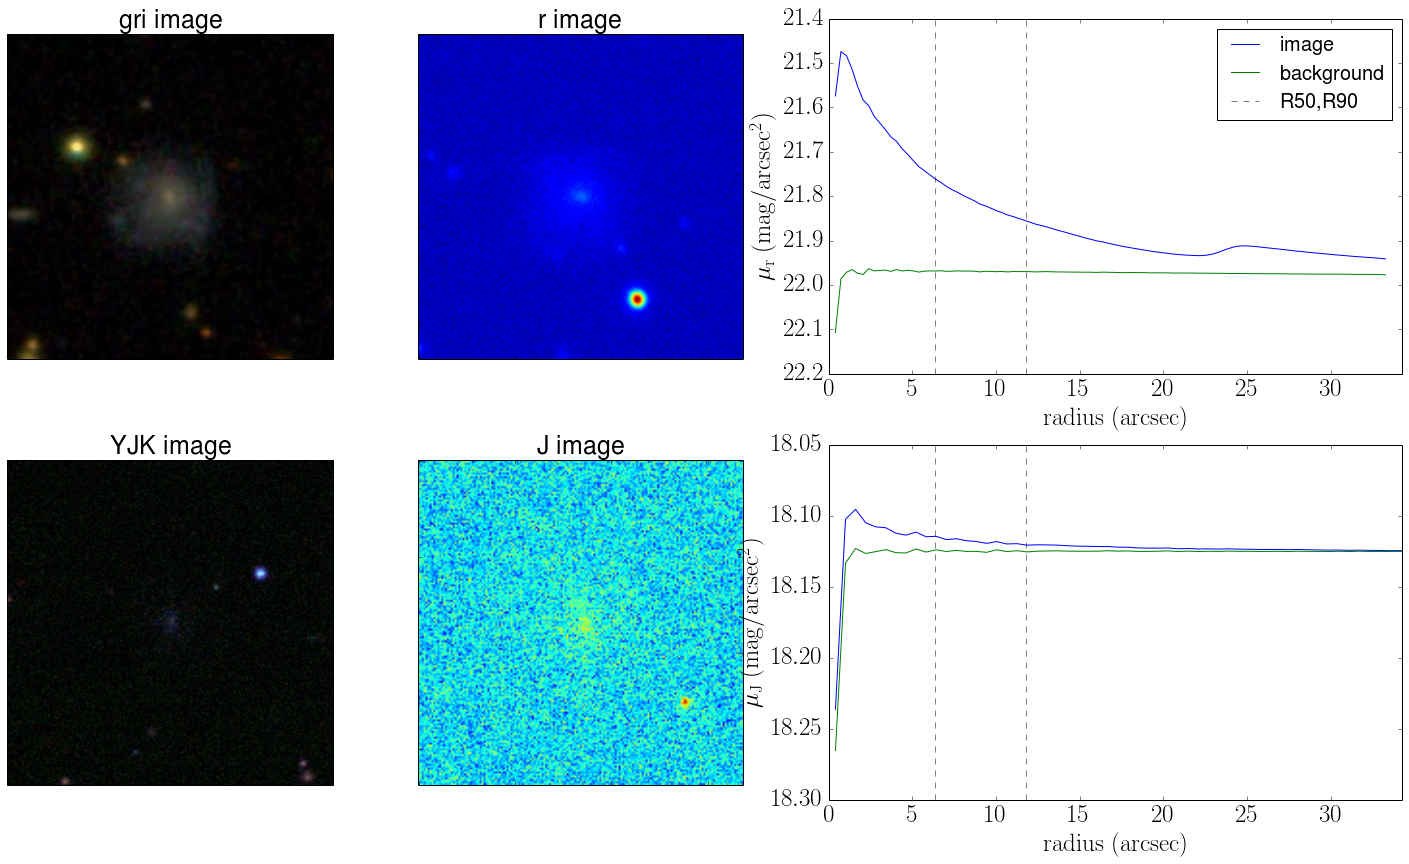

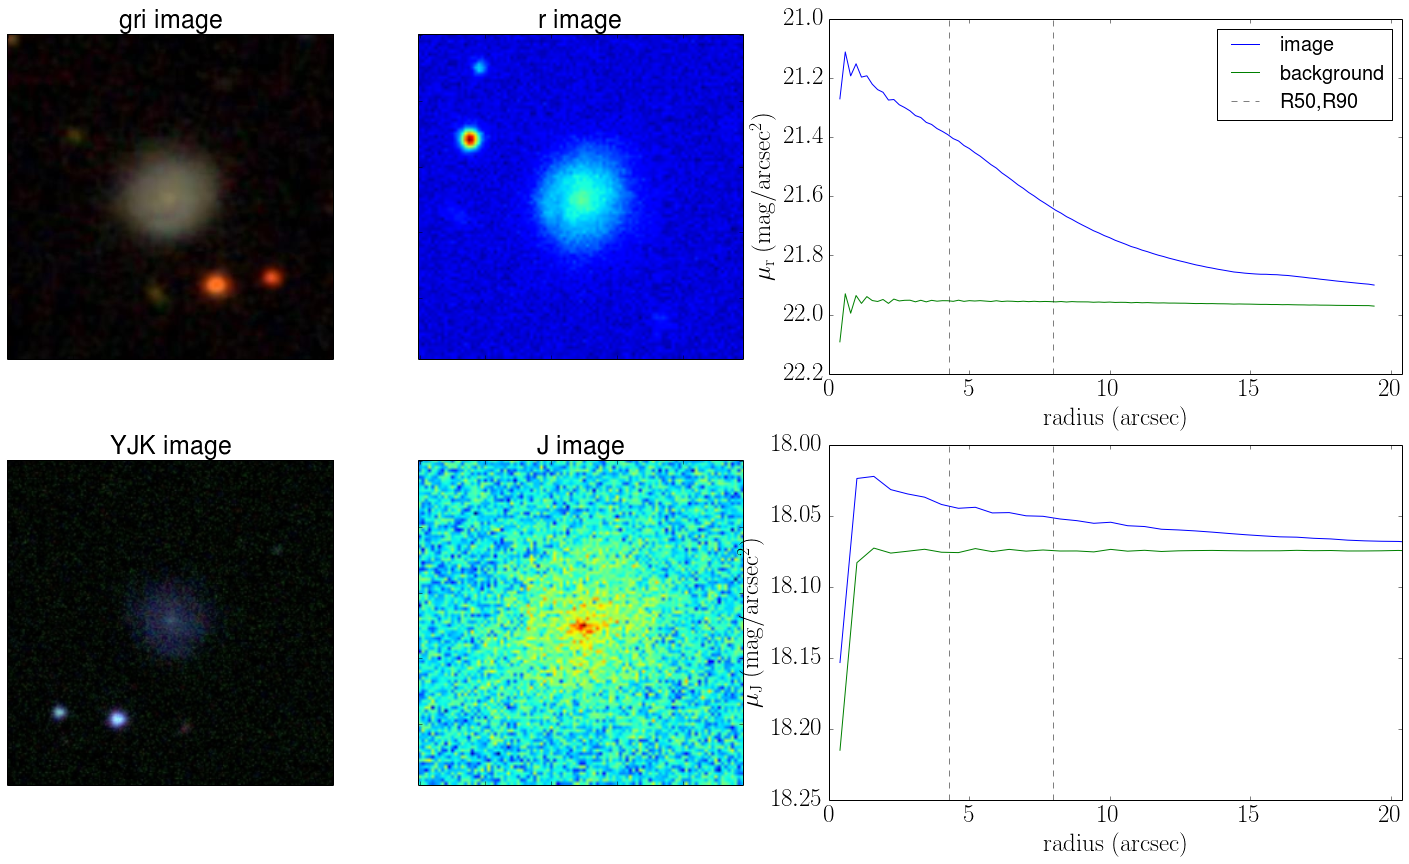

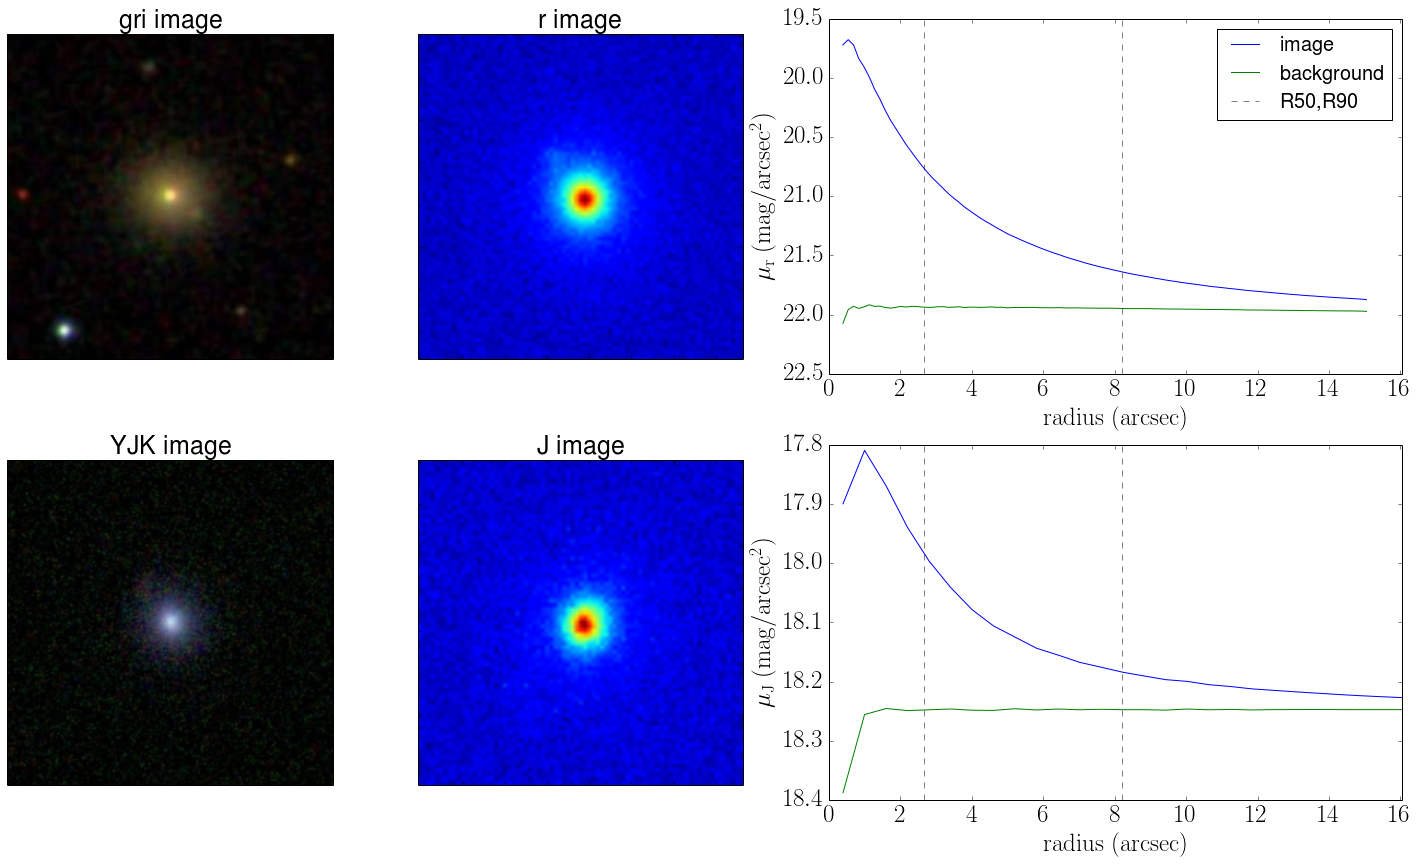

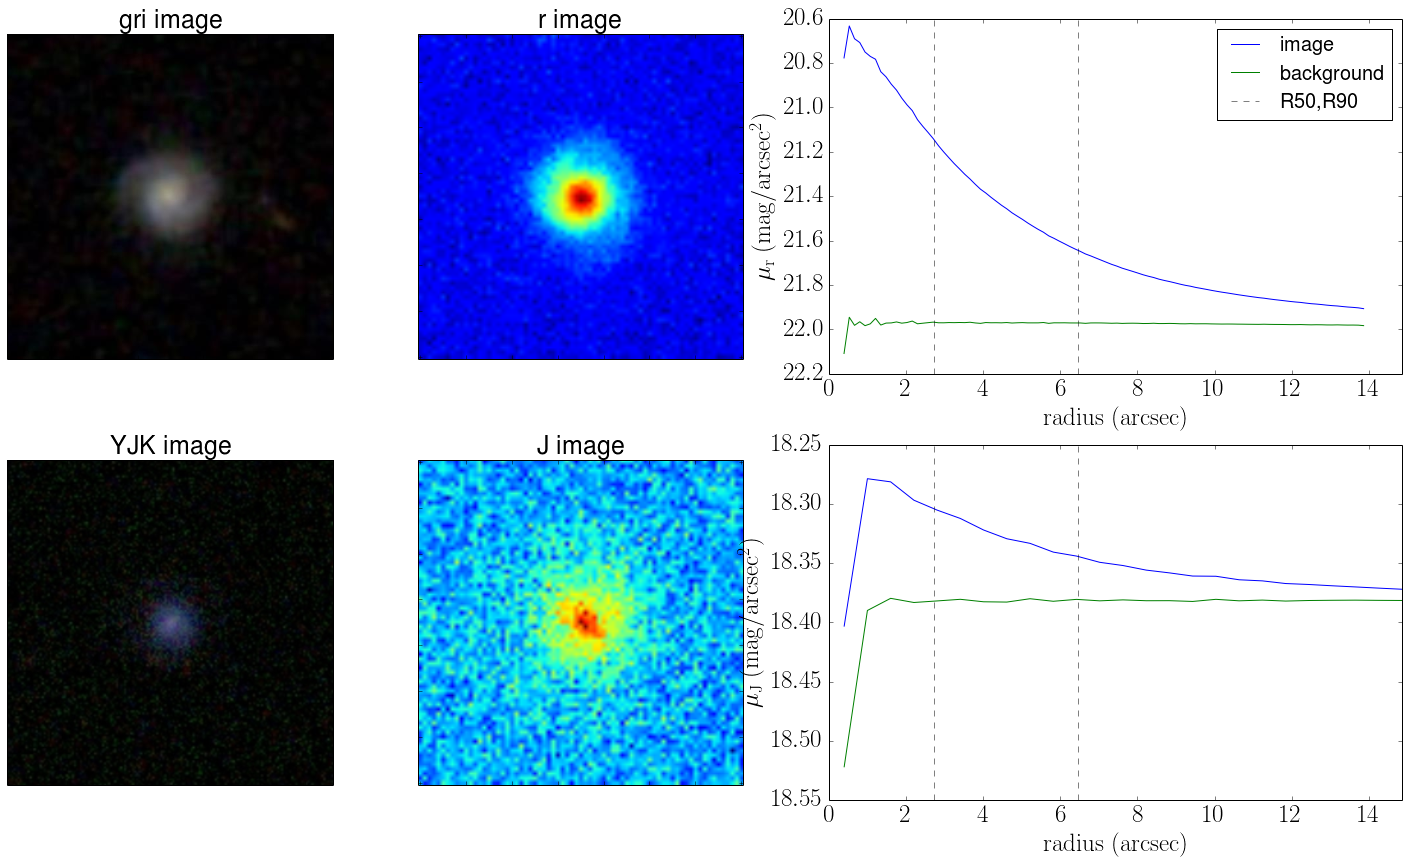

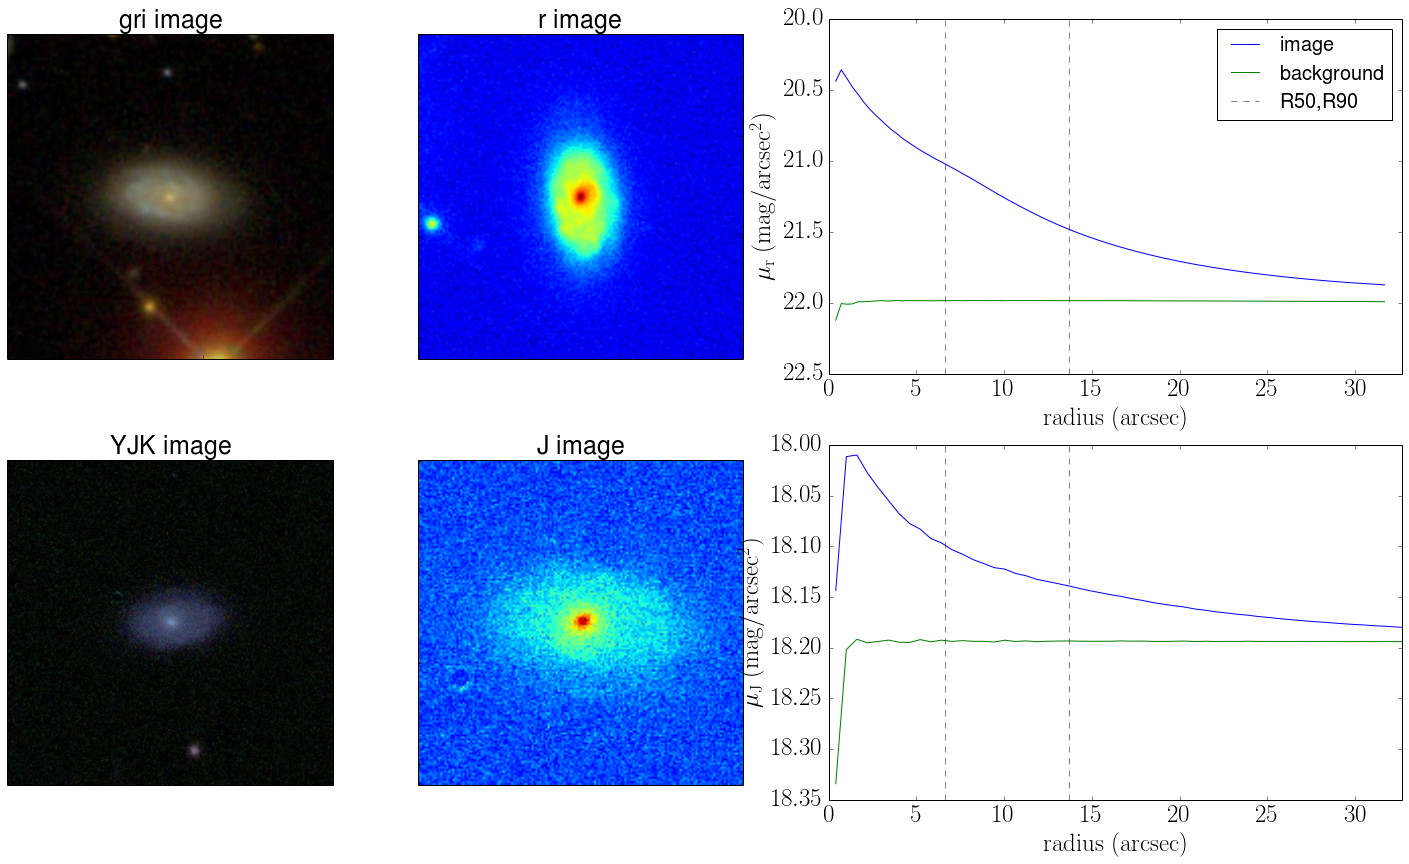

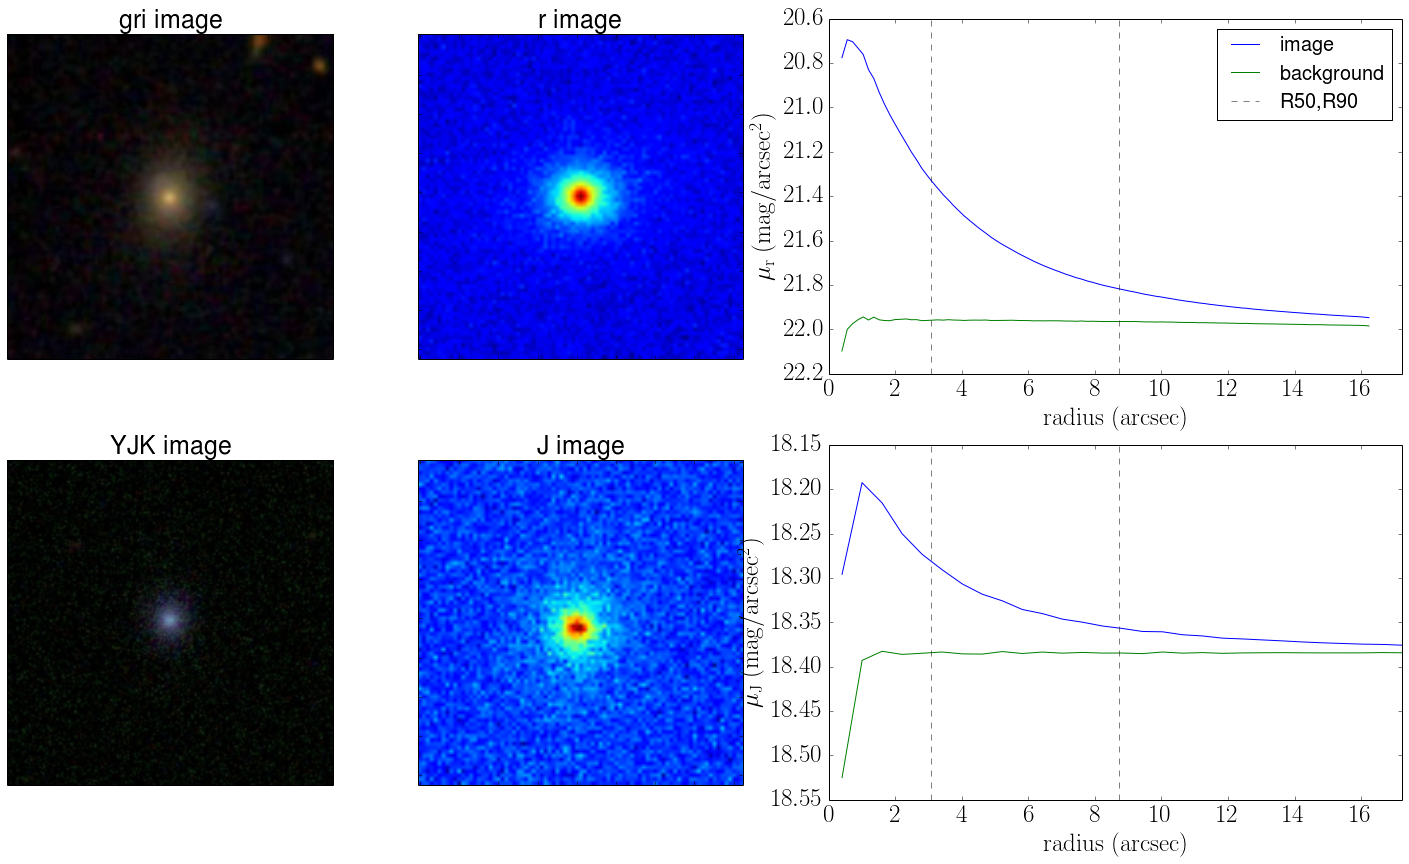

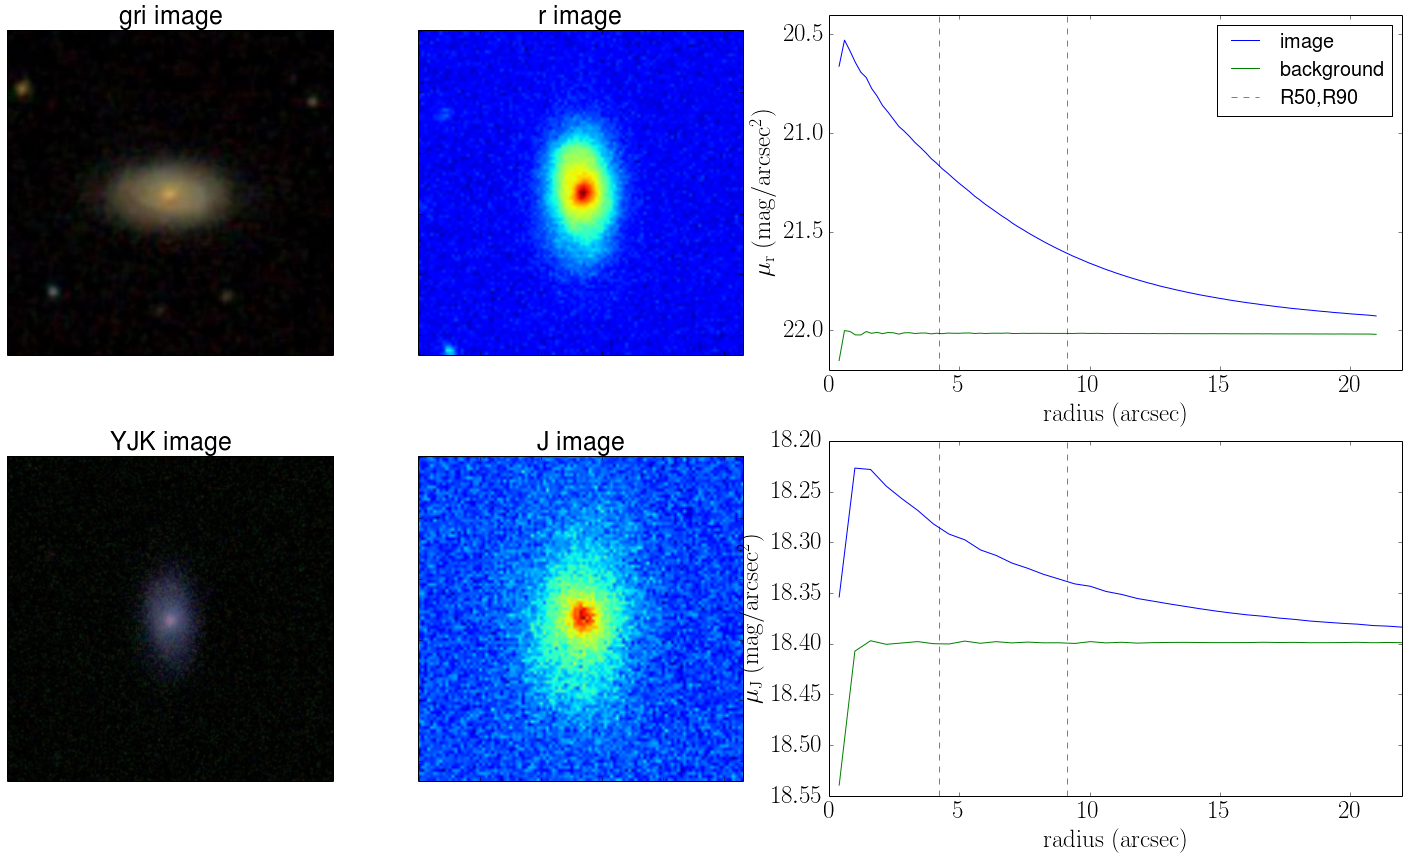

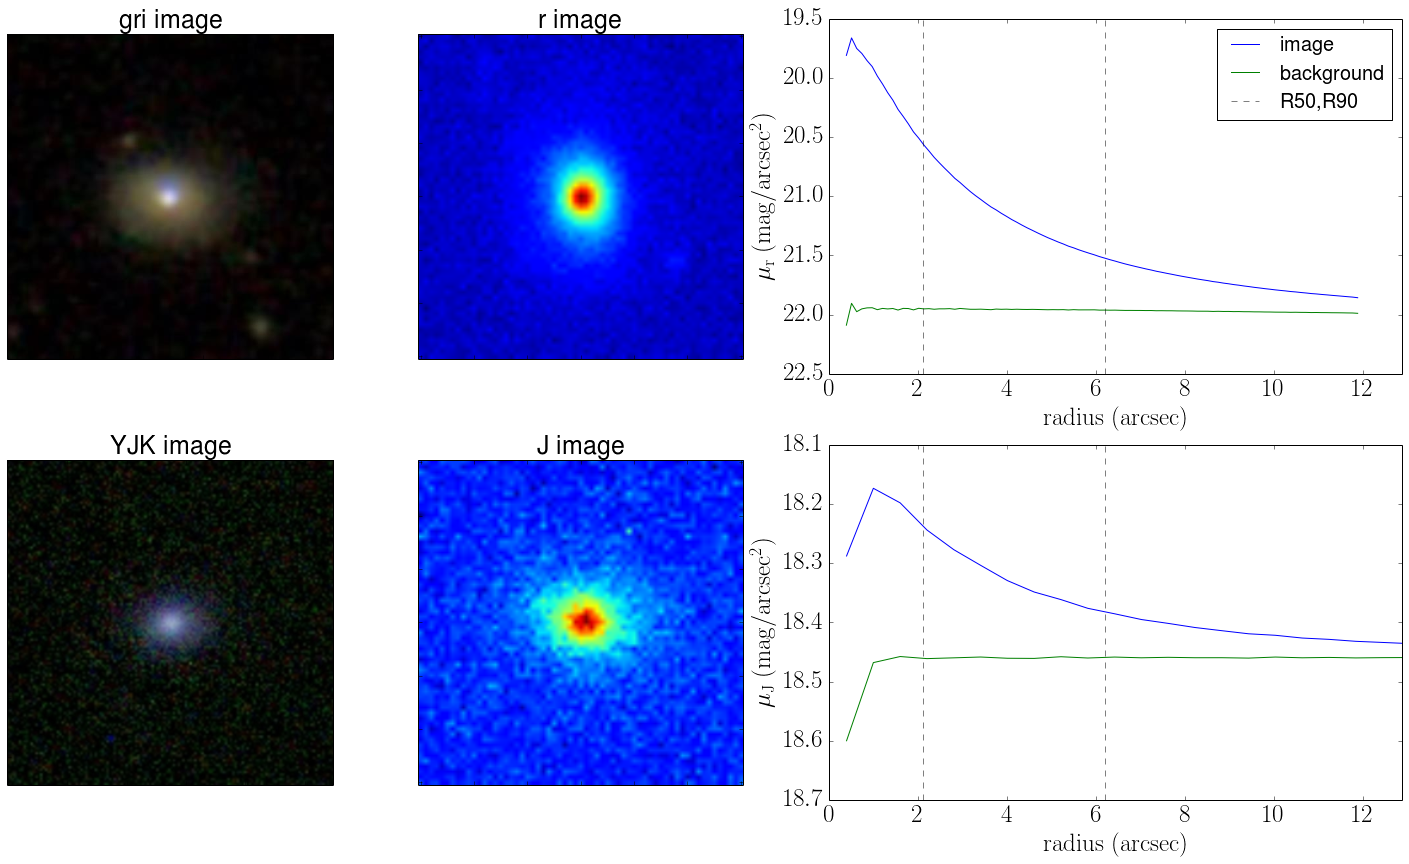

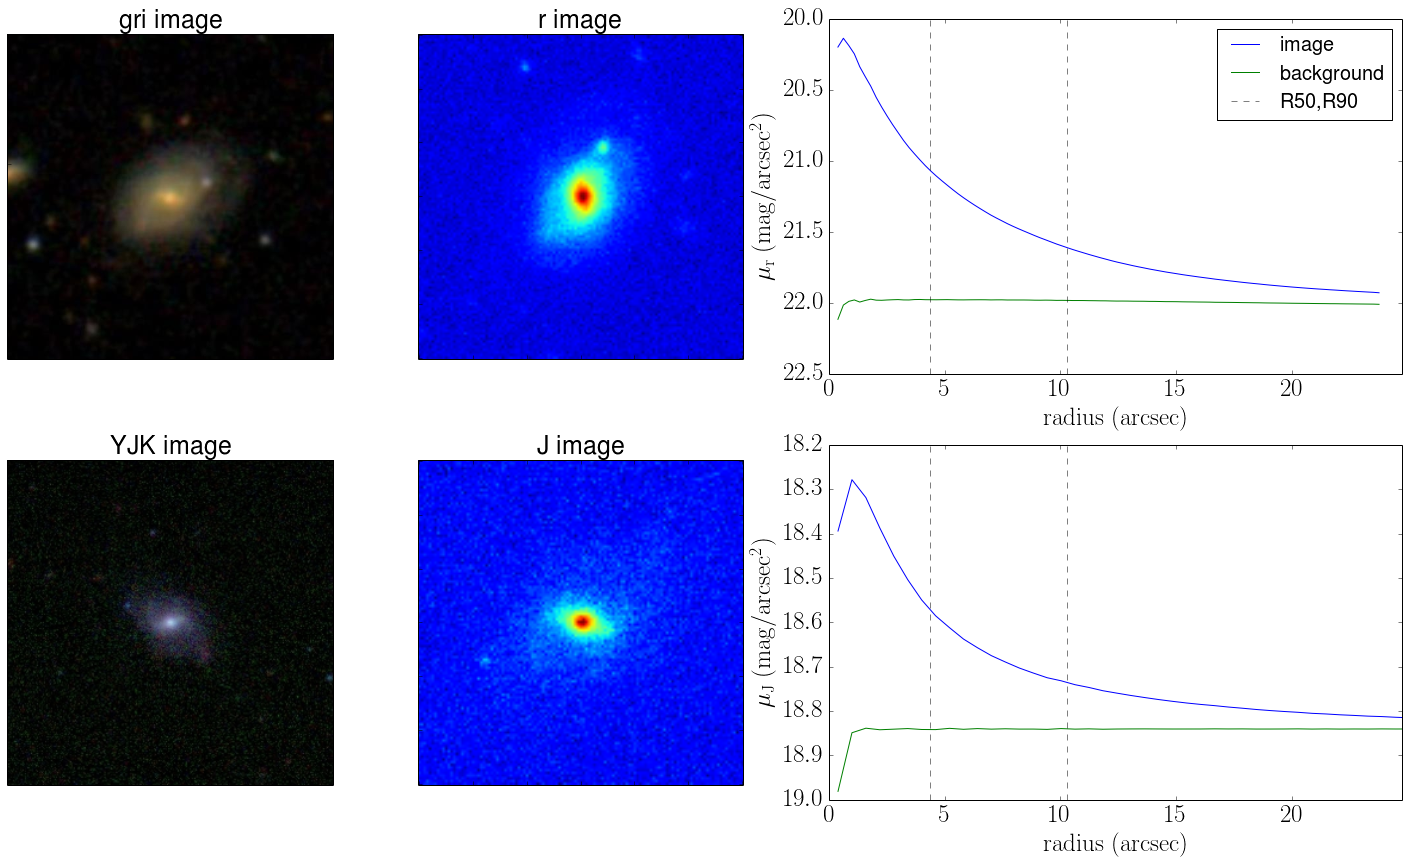

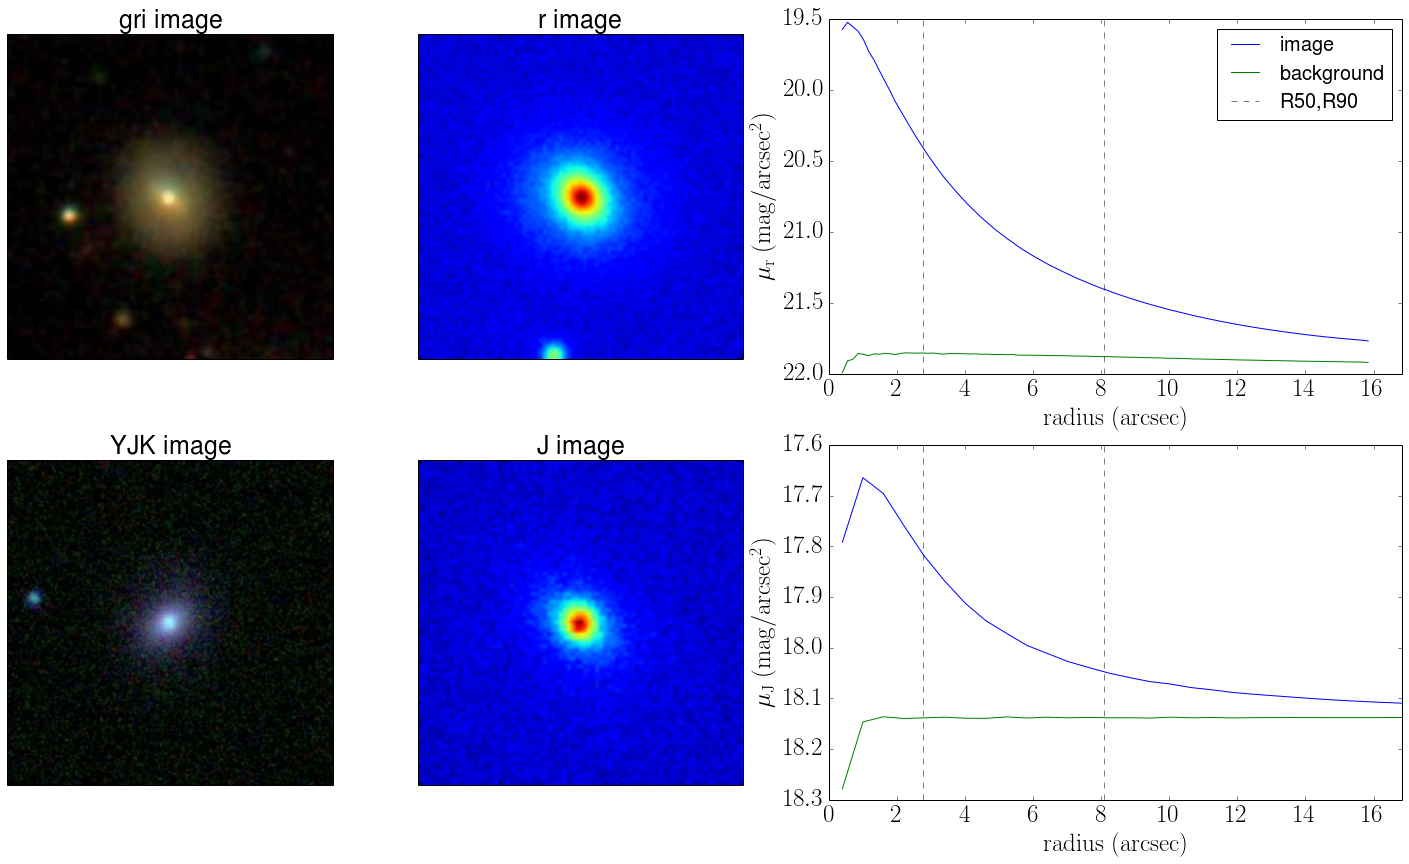

In [86]:
for i in range(0,10):
    gal = vol_lim[i]
    calc_and_plot(gal)


In [7]:
from astropy.modeling import models, fitting


In [8]:
i=4
frame = fits.open(get_filename(vol_lim[i]))
tsf = fits.open(get_tsfname(vol_lim[i]))
gal = vol_lim[i]
cutout,radii,sb,sb_bkg = get_sb_profile(vol_lim[i],frame,tsf)


STRIP   ='S          '         / Strip in the stripe being tracked.              [astropy.io.fits.card]
STRIP   ='S          '         / Strip in the stripe being tracked.             
FLAVOR  ='science    '         / Flavor of this run                              [astropy.io.fits.card]
FLAVOR  ='science    '         / Flavor of this run                             
SYS_SCN ='mean       '         / System of the scan great circle (e.g., mean)    [astropy.io.fits.card]
SYS_SCN ='mean       '         / System of the scan great circle (e.g., mean)   
OBJECT  ='10 S       '         / e.g., 'stripe 50.6 degrees, north strip'        [astropy.io.fits.card]
OBJECT  ='10 S       '         / e.g., 'stripe 50.6 degrees, north strip'       
EXPTIME ='53.907456'           / Exposure time (seconds)                         [astropy.io.fits.card]
EXPTIME ='53.907456'           / Exposure time (seconds)                        
DAVERS  ='v12_6   '            / Version of DA software                    

In [19]:
#flux = flux*10**9
flux=cutout

In [21]:
counts_to_f_f0(flux)

TypeError: counts_to_f_f0() takes at least 4 arguments (1 given)

MemoryError: 

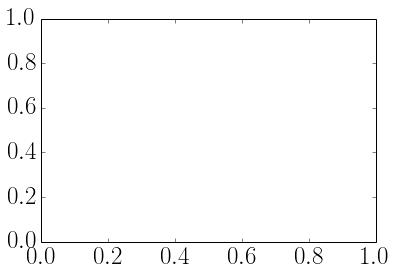

In [17]:
min_flux = np.min(flux)
mean_estimate = np.average(flux)
sig_estimate = (mean_estimate-min_flux)/2
max_flux = mean_estimate+sig_estimate*4
#bin_width = 1 # for counts
bin_width = .01 #for flux

n_bins = int((max_flux-min_flux)/bin_width)
hist,bin_edges,c=plt.hist(np.ravel(flux),bins=n_bins,range=(min_flux,max_flux))
bin_halfwidth = (bin_edges[1]-bin_edges[0])/2.
bin_centers = [b+bin_halfwidth for b in bin_edges][:-1]


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


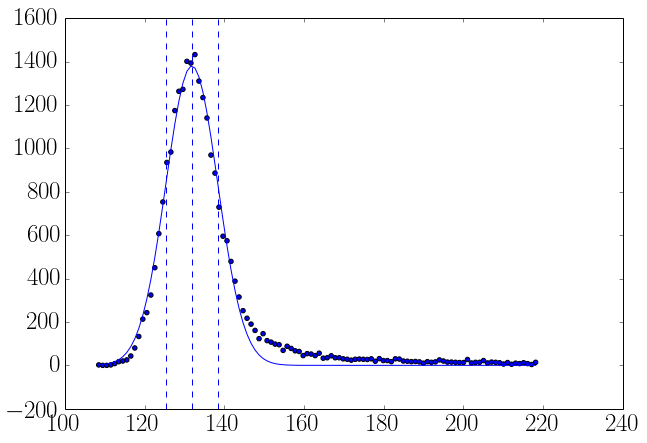

In [12]:
f=plt.figure(figsize=(10,7))
g_init = models.Gaussian1D(amplitude=max_flux, mean=mean_estimate, stddev=sig_estimate)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, bin_centers, hist)

plt.scatter(bin_centers,hist)
plt.plot(bin_centers, g(bin_centers), label='Gaussian')
plt.axvline(g.mean.value,ls='dashed')
plt.axvline(g.mean.value+g.stddev.value,ls='dashed')
plt.axvline(g.mean.value-g.stddev.value,ls='dashed')

In [13]:
def measure_sn(gal,frame,tsf):

    ra = gal['RA']
    dec = gal['DEC']
    rad = gal['petrorad_r']
    
    img = frame[0].data
    hdr = frame[0].header

    #get coordinates of subject
    w = wcs.WCS(hdr)
    pix = w.wcs_world2pix(ra, dec,1)
    row, col = int(pix[1]), int(pix[0])

    size = 6. #total size of cutout = 8*petro_r
    extents = [int(row-size*rad), int(row+size*rad), int(col-size*rad), int(col+size*rad)] 
    cutout = img[extents[0]:extents[1], extents[2]:extents[3]]

    #zeropoints, extinction, and airmass 
    r_zero,r_kk,r_airmass = tsf_params(tsf)
    
    center_pix = cutout.shape[0]/2+1 #center of galaxy / cutout
    positions = [(center_pix,center_pix)] #center of aperture
    radii = np.linspace(1,center_pix-1,100) #100 apertures
    
    #subtract padding from cutout
    cutout = cutout - hdr['SOFTBIAS']
    
    #subtract sky 
    cutout_minus_bkg,bkg = subtract_sky(cutout,5)
    
    avg_flux_per_pixel = []
    for r in radii: #calculate counts for each aperture with radius r
        apertures = CircularAperture(positions,r=r)
        phot_table = aperture_photometry(cutout,apertures,method='subpixel')
        counts_in_aperture = phot_table['aperture_sum']

        flux_in_aperture = counts_to_f_f0(counts_in_aperture,r_zero,r_kk,r_airmass) #convert counts to f/f0
        flux_in_aperture = counts_in_aperture
        #flux_in_aperture = flux_in_aperture*(10**9)
        n_pixels = np.pi*(r**2) #number of pixels in area
        flux_per_pixel = float(flux_in_aperture)/n_pixels
        
        avg_flux_per_pixel.append(flux_per_pixel) #flux per pixel at radius r

    return cutout,radii*.396,avg_flux_per_pixel  


In [14]:
cutout,radii,flux_per_pixel = measure_sn(gal,frame,tsf)

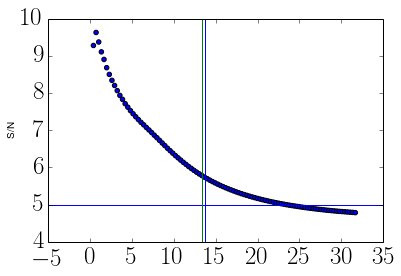

In [15]:
plt.scatter(radii,np.sqrt(flux_per_pixel/g.stddev.value))
plt.ylabel('S/N')
plt.axhline(5)
plt.axvline(gal['petrorad_r'],c='g')
plt.axvline(gal['PETROR90_R'])

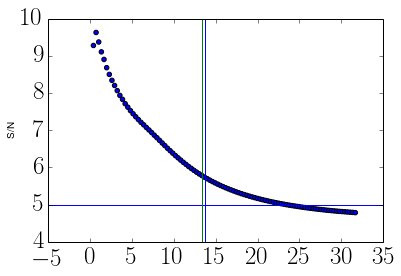

In [315]:
plt.scatter(radii,np.sqrt(flux_per_pixel/g.stddev.value))
plt.ylabel('S/N')
plt.axhline(5)
plt.axvline(gal['petrorad_r'],c='g')
plt.axvline(gal['PETROR90_R'])

In [179]:
sig_estimate = (mean_estimate-min_flux)*2

In [180]:
sig_estimate

51.303875914708897

In [285]:
    r_zero,r_kk,r_airmass = tsf_params(tsf)


292.56356570148114